# Recommander System

This demo is derived from this [article](https://datascienceplus.com/building-a-book-recommender-system-the-basics-knn-and-matrix-factorization/)

Agenda
- Dataset
- k Nearest Neighbor


## Dataset

Book-Crossings is a book rating dataset compiled by Cai-Nicolas Ziegler. It contains 1.1 million ratings of 270,000 books by 90,000 users. The ratings are on a scale from 1 to 10.

The data consists of three tables: ratings, books info, and users info.

In [7]:
# !wget http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
# !unzip ./BX-CSV-Dump.zip -d ./data

Archive:  ./BX-CSV-Dump.zip
  inflating: ./data/BX-Book-Ratings.csv  
  inflating: ./data/BX-Books.csv     
  inflating: ./data/BX-Users.csv     


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
books = pd.read_csv('./data/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('./data/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('./data/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:27

### Ratings data

In [10]:
print(ratings.shape)
print(list(ratings.columns))

(1149780, 3)
['userID', 'ISBN', 'bookRating']


In [11]:
ratings.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Ratings distribution

The ratings are very unevenly distributed, and the vast majority of ratings are 0

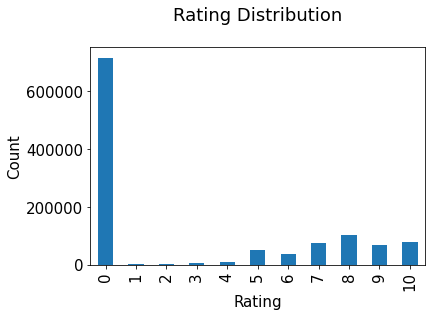

In [12]:
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
# plt.savefig('system1.png', bbox_inches='tight')
plt.show()

### Book data

In [13]:
print(books.shape)
print(list(books.columns))

(271360, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [14]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### User data

In [15]:
print(users.shape)
print(list(users.columns))

(278858, 3)
['userID', 'Location', 'Age']


In [16]:
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### Age distribution

The most active users are among those in their 20–30s

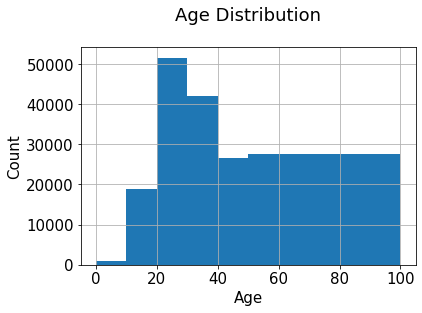

In [17]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
# plt.savefig('system2.png', bbox_inches='tight')
plt.show()

## Collaborative Filtering Using k-Nearest Neighbors (kNN)

kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors.

Starting from the original data set, we will be only looking at the popular books. In order to find out which books are popular, we combine books data with ratings data.

In [18]:
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


We then group by book titles and create a new column for total rating count.

In [19]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])

book_ratingCount = (combine_book_rating.
     groupby(by = ['bookTitle'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['bookTitle', 'totalRatingCount']]
    )
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


We combine the rating data with the total rating count data, this gives us exactly what we need to find out which books are popular and filter out lesser-known books.

In [20]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,276725,034545104X,0,Flesh Tones: A Novel,60
1,2313,034545104X,5,Flesh Tones: A Novel,60
2,6543,034545104X,0,Flesh Tones: A Novel,60
3,8680,034545104X,5,Flesh Tones: A Novel,60
4,10314,034545104X,9,Flesh Tones: A Novel,60


In [21]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.90     7.0
0.91     8.0
0.92     9.0
0.93    10.0
0.94    11.0
0.95    13.0
0.96    16.0
0.97    20.0
0.98    29.0
0.99    50.0
Name: totalRatingCount, dtype: float64


About 1% of the books received 50 or more ratings. Because we have so many books in our data, we will limit it to the top 1%, and this will give us 2713 unique books.

In [22]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,276725,034545104X,0,Flesh Tones: A Novel,60
1,2313,034545104X,5,Flesh Tones: A Novel,60
2,6543,034545104X,0,Flesh Tones: A Novel,60
3,8680,034545104X,5,Flesh Tones: A Novel,60
4,10314,034545104X,9,Flesh Tones: A Novel,60


### Filter to users in US and Canada only

In order to improve computing speed, and not run into the “MemoryError” issue, I will limit our user data to those in the US and Canada. And then combine user data with the rating data and total rating count data.

In [23]:
combined = rating_popular_book.merge(users, left_on = 'userID', right_on = 'userID', how = 'left')

us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating=us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,276725,034545104X,0,Flesh Tones: A Novel,60,"tyler, texas, usa"
1,2313,034545104X,5,Flesh Tones: A Novel,60,"cincinnati, ohio, usa"
2,6543,034545104X,0,Flesh Tones: A Novel,60,"strafford, missouri, usa"
3,8680,034545104X,5,Flesh Tones: A Novel,60,"st. charles county, missouri, usa"
4,10314,034545104X,9,Flesh Tones: A Novel,60,"beaverton, oregon, usa"


We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors). We then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.

### Finding the Nearest Neighbors

We use unsupervised algorithms with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is “brute”, and we specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors. Finally, we fit the model.

In [25]:
from scipy.sparse import csr_matrix
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

### Test model

In this step, the kNN algorithm measures distance to determine the “closeness” of instances. It then classifies an instance by finding its nearest neighbors, and picks the most popular class among the neighbors.

In [27]:
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Storm Warning:

1: False Pretenses, with distance of 0.6622357482128597:
2: Honest Illusions, with distance of 0.7685238385767539:
3: True Betrayals, with distance of 0.775259634409938:
4: Macgregor Brides (Macgregors), with distance of 0.8015482287733886:
5: Jewels of the Sun (Irish Trilogy), with distance of 0.8020709389966487:


## Collaborative Filtering Using Matrix Factorization

Matrix Factorization is simply a mathematical tool for playing around with matrices. The Matrix Factorization techniques are usually more effective, because they allow users to discover the latent (hidden)features underlying the interactions between users and items (books).

We use singular value decomposition (SVD) — one of the Matrix Factorization models for identifying latent factors.

In [28]:
us_canada_user_rating_pivot2 = us_canada_user_rating.pivot(index = 'userID', columns = 'bookTitle', values = 'bookRating').fillna(0)
us_canada_user_rating_pivot2.head()

bookTitle,10 Lb. Penalty,16 Lighthouse Road,1984,1st to Die: A Novel,2010: Odyssey Two,204 Rosewood Lane,2061: Odyssey Three,24 Hours,2nd Chance,3rd Degree,4 Blondes,50 Simple Things You Can Do to Save the Earth,84 Charing Cross Road,A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Civil Action,A Clockwork Orange (Norton Paperback Fiction),A Cold Heart (Alex Delaware Novels (Paperback)),A Cold Heart: An Alex Delaware Novel,A Confederacy of Dunces,A Confederacy of Dunces (Evergreen Book),A Cry In The Night,A Cup of Tea (Ballantine Reader's Circle),A Dangerous Fortune,A Darkness More Than Night,A Day Late and a Dollar Short,A Density of Souls,A Fine Balance,"A Game of Thrones (A Song of Ice and Fire, Book 1)",A Girl Named Zippy: Growing Up Small in Mooreland Indiana (Today Show Book Club #3),A Great Deliverance,A Heartbreaking Work Of Staggering Genius : A Memoir Based on a True Story,A Heartbreaking Work of Staggering Genius,A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),A Kiss of Shadows (Meredith Gentry Novels (Paperback)),A Knight in Shining Armor,A Lesson Before Dying (Vintage Contemporaries (Paperback)),...,Wild Justice,Wild Mountain Thyme,Wild Swans: Three Daughters of China,Windmills of the Gods,Windy City Blues (V.I. Warshawski Novels (Paperback)),Wings,Winter Moon,Winter Prey,Winter Solstice,"Winter's Heart (The Wheel of Time, Book 9)",Winter's Tale,Wish You Well,Without Remorse,Witness in Death (Eve Dallas Mysteries (Paperback)),"Wizard and Glass (The Dark Tower, Book 4)","Wizard's First Rule (Sword of Truth, Book 1)",Wobegon Boy,Woman on the Edge of Time,Women Who Run with the Wolves,Women in His Life,Women of the Silk : A Novel,"Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players",World of Pies : A Novel,Wouldn't Take Nothing for My Journey Now,Writ of Execution,Writing Down the Bones,Wuthering Heights,Wuthering Heights (Penguin Classics),Wuthering Heights (Wordsworth Classics),Xenocide (Ender Wiggins Saga (Paperback)),YOU BELONG TO ME,Year of Wonders,You Belong To Me,You Shall Know Our Velocity,Young Wives,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw""","\Surely You're Joking, Mr. Feynman!\"": Adventures of a Curious Character""",stardust
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

We then transpose this utility matrix, so that the bookTitles become rows and userIDs become columns. After using TruncatedSVD to decompose it, we fit it into the model for dimensionality reduction. This compression happened on the dataframe’s columns since we must preserve the book titles. We choose n_components = 12 for just 12 latent variables, and you can see, our data’s dimensions have been reduced significantly from 40017 X 2442 to 2442 X 12.

In [29]:
us_canada_user_rating_pivot2.shape

(40017, 2442)

In [30]:
X = us_canada_user_rating_pivot2.values.T
X.shape

(2442, 40017)

In [31]:
import sklearn
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=12, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

(2442, 12)

We calculate the Pearson’s R correlation coefficient for every book pair in our final matrix. To compare this with the results from kNN, we pick the same book “The Green Mile: Coffey’s Hands (Green Mile Series)” to find the books that have high correlation coefficients (between 0.9 and 1.0) with it.

In [32]:
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape

(2442, 2442)

In [39]:
us_canada_book_title = us_canada_user_rating_pivot2.columns
us_canada_book_list = list(us_canada_book_title)
book_index = us_canada_book_list.index("Storm Warning")
print(book_index)

1604


In [44]:
corr_book_index  = corr[book_index]
list(us_canada_book_title[(corr_book_index >= 0.99 )])

['Genuine Lies',
 'Public Secrets',
 'Sacred Sins',
 'Stanislaski Brothers (Silhouette Promo)',
 'Storm Warning',
 'The Scottish Bride (Bride Trilogy (Paperback))']

False Pretenses, with distance of 0.6622357482128597:
2: Honest Illusions, with distance of 0.7685238385767539:
3: True Betrayals, with distance of 0.775259634409938:
4: Macgregor Brides (Macgregors), with distance of 0.8015482287733886:
5: Jewels of the Sun (Irish Trilogy), with distance of 0.8020709389966487:
